# 🛫 1. Introdução

## ✈️ FlightOnTime – Previsão de Atraso de Voos

Este notebook constrói um modelo de Machine Learning capaz de prever se um voo será:

- **0 → Pontual**
- **1 → Atrasado**

Com base em variáveis históricas como:

- Companhia aérea  
- Aeroporto de origem e destino  
- Horário programado  
- Distância  
- Atraso na partida  

Etapas do notebook:

1. Importação do dataset (Flight Delays 2015 — US DOT)
2. Análise exploratória (EDA)
3. Criação de variáveis (feature engineering)
4. Treinamento de múltiplos modelos
5. Comparação de desempenho
6. Escolha do melhor modelo
7. Exportação para uso no Back-End

O objetivo final é integrar este modelo a uma **API em Java (Spring Boot)** para o Hackathon ONE.

# 🧩 2. Importação das bibliotecas


In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

import joblib
import warnings
warnings.filterwarnings("ignore")


# 📂 3. Carregando o dataset


In [2]:
if IN_COLAB:
    drive.mount('/content/drive', force_remount=True)
    base_dir = '/content/drive/MyDrive'
else:
    base_dir = os.getcwd()

data_path = os.getenv('FLIGHTS_CSV_PATH', os.path.join(base_dir, 'flights.csv'))
if not os.path.exists(data_path):
    raise FileNotFoundError(
        f"Arquivo nao encontrado: {data_path}. "
        "Defina FLIGHTS_CSV_PATH ou coloque flights.csv no diretorio."
    )

df = pd.read_csv(data_path)

model_output_path = os.getenv(
    'MODEL_OUTPUT_PATH',
    os.path.join(base_dir, 'modelo_final.joblib')
)


Mounted at /content/drive


# 🧩 4. Visão geral do dataset

Antes de criar a variável-alvo e treinar modelos, vamos entender melhor os dados:

- Quantidade de linhas e colunas  
- Primeiras linhas do dataset  
- Tipos de dados de cada coluna  
- Valores ausentes  
- Distribuição básica dos atrasos (`DEPARTURE_DELAY`) e status de cancelamento / desvio  


In [3]:
# Dimensões do dataset
print("Formato do dataset (linhas, colunas):", df.shape)

Formato do dataset (linhas, colunas): (5819079, 31)


In [4]:
# Primeiras linhas
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Tipos de dados
df.dtypes

,0
YEAR,int64
MONTH,int64
DAY,int64
DAY_OF_WEEK,int64
AIRLINE,object
FLIGHT_NUMBER,int64
TAIL_NUMBER,object
ORIGIN_AIRPORT,object
DESTINATION_AIRPORT,object
SCHEDULED_DEPARTURE,int64


In [6]:
# Estatísticas descritivas das colunas numéricas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
YEAR,5819079.0,2015.000000,0.000000,2015.0,2015.0,2015.0,2015.0,2015.0
MONTH,5819079.0,6.524085,3.405137,1.0,4.0,7.0,9.0,12.0
DAY,5819079.0,15.704594,8.783425,1.0,8.0,16.0,23.0,31.0
DAY_OF_WEEK,5819079.0,3.926941,1.988845,1.0,2.0,4.0,6.0,7.0
FLIGHT_NUMBER,5819079.0,2173.092742,1757.063999,1.0,730.0,1690.0,3230.0,9855.0
SCHEDULED_DEPARTURE,5819079.0,1329.602470,483.751821,1.0,917.0,1325.0,1730.0,2359.0
DEPARTURE_TIME,5732926.0,1335.204439,496.423260,1.0,921.0,1330.0,1740.0,2400.0
DEPARTURE_DELAY,5732926.0,9.370158,37.080942,-82.0,-5.0,-2.0,7.0,1988.0
TAXI_OUT,5730032.0,16.071662,8.895574,1.0,11.0,14.0,19.0,225.0
WHEELS_OFF,5730032.0,1357.170841,498.009356,1.0,935.0,1343.0,1754.0,2400.0


In [7]:
# Verificando valores ausentes por coluna
df.isna().sum().sort_values(ascending=False)

,0
CANCELLATION_REASON,5729195
LATE_AIRCRAFT_DELAY,4755640
WEATHER_DELAY,4755640
AIRLINE_DELAY,4755640
AIR_SYSTEM_DELAY,4755640
SECURITY_DELAY,4755640
ELAPSED_TIME,105071
AIR_TIME,105071
ARRIVAL_DELAY,105071
WHEELS_ON,92513


In [8]:
# Quantidade de voos cancelados e desviados
print("Cancelados:", df['CANCELLED'].sum())
print("Desviados :", df['DIVERTED'].sum())

Cancelados: 89884
Desviados : 15187


In [9]:
# Distribuição de atrasos na saída
df['DEPARTURE_DELAY'].describe()

,DEPARTURE_DELAY
count,5.732926e+06
mean,9.370158e+00
std,3.708094e+01
min,-8.200000e+01
25%,-5.000000e+00
50%,-2.000000e+00
75%,7.000000e+00
max,1.988000e+03


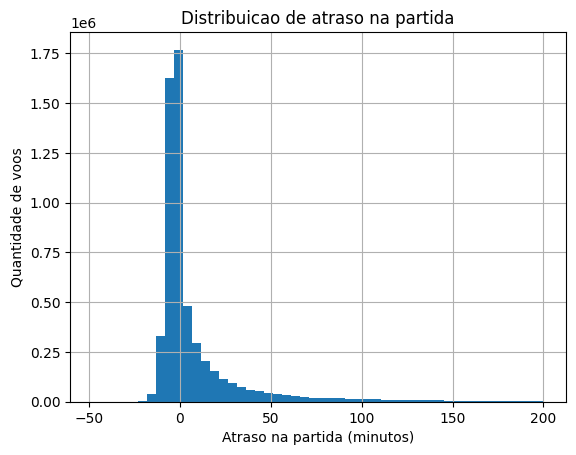

In [10]:
# Histograma de atraso na partida (limitando para atrasos razoaveis, ex: entre -50 e 200 minutos)
df[df['DEPARTURE_DELAY'].between(-50, 200)]['DEPARTURE_DELAY'].hist(bins=50)
plt.xlabel("Atraso na partida (minutos)")
plt.ylabel("Quantidade de voos")
plt.title("Distribuicao de atraso na partida")
plt.show()


# 🧹 5. Limpeza dos Dados e Feature Engineering

Antes de treinar os modelos, precisamos preparar o dataset.  
Nesta seção, faremos:

- Remoção de colunas que causam *data leakage*  
- Remoção de voos cancelados e desviados  
- Criação da variável-alvo (TARGET)  
- Criação de novas features relevantes (ex.: hora de partida)  
- Codificação de variáveis categóricas  
- Separação entre X (features) e y (alvo)  
- Divisão entre treino e teste  


## ✔️ 5.1 Removendo colunas que causam data leakage

As colunas abaixo representam **motivos do atraso**, registrados somente após o voo acontecer.  
Como queremos prever o atraso **antes do voo**, essas variáveis vazam informação do futuro e devem ser removidas.

Colunas a remover:

- `AIR_SYSTEM_DELAY`
- `SECURITY_DELAY`
- `AIRLINE_DELAY`
- `LATE_AIRCRAFT_DELAY`
- `WEATHER_DELAY`


In [11]:
colunas_para_remover = [
    'AIR_SYSTEM_DELAY',
    'SECURITY_DELAY',
    'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'WEATHER_DELAY',
    'CANCELLATION_REASON'
]

df = df.drop(columns=colunas_para_remover)
df.shape


(5819079, 25)

## ❌ 5.2 Removendo voos cancelados e desviados

Para treinar um modelo preditivo confiável, devemos manter apenas voos que **realmente ocorreram**.  
Voos cancelados (`CANCELLED = 1`) ou desviados (`DIVERTED = 1`) não possuem horários reais de chegada, portanto **não servem para prever atraso**.

### 🛑 Por que remover essas linhas?

- Não possuem `DEPARTURE_DELAY` confiável.
- Representam comportamentos especiais (eventos raros) que **poluem o treino**.
- Não fazem parte do objetivo do projeto FlightOnTime, que é prever **se um voo irá atrasar**, assumindo que ele irá decolar.
- Podem distorcer significativamente as métricas.

### ✔️ Regra aplicada:
Manter somente voos onde:

- `CANCELLED == 0`
- `DIVERTED == 0`


In [12]:
# Removendo voos cancelados e desviados
df = df[(df['CANCELLED'] == 0) & (df['DIVERTED'] == 0)]


In [13]:
# Confirmando o novo tamanho do dataset
print("Novo tamanho do dataset:", df.shape)


Novo tamanho do dataset: (5714008, 25)


## 🎯 5.3 Criando a variável-alvo (TARGET)

Nosso objetivo é prever se um voo **irá decolar com atraso**.

Para isso, precisamos transformar a coluna `DEPARTURE_DELAY` em uma variável binária que indique se o voo saiu no horário ou com atraso.

---

### 🔍 Definição das classes

- **0 → Pontual** (voo decolou no horário ou adiantado)
- **1 → Atrasado** (voo decolou com atraso)

---

### 📌 Definição usada na indústria

Um voo é considerado **atrasado na decolagem** quando sai **15 minutos ou mais depois do horário previsto**.

Esse critério segue o padrão adotado pelo **Departamento de Transportes dos Estados Unidos (US DOT)**, amplamente utilizado em análises de pontualidade no setor aéreo.

---

### 💡 Por que transformar a variável?

- Modelos de classificação supervisionada exigem um **alvo discreto (0/1)**  
- Trabalhar diretamente com minutos de atraso tornaria o problema mais complexo  
- A abordagem binária é mais adequada para um **MVP preditivo** e para consumo via API

---

### ✅ Regra aplicada

Criamos a coluna `TARGET` seguindo a regra:

- `TARGET = 1` se `DEPARTURE_DELAY >= 15`
- `TARGET = 0` caso contrário


In [14]:
# Removendo NaN de DEPARTURE_DELAY antes de criar a variável-alvo
df = df.dropna(subset=['DEPARTURE_DELAY'])

# Criando a variável-alvo (TARGET) com base no atraso na saída
df['TARGET'] = (df['DEPARTURE_DELAY'] >= 15).astype(int)


In [15]:
# Visualizando a distribuição da variável-alvo
df['TARGET'].value_counts(normalize=True)


,proportion
TARGET,
0,0.816167
1,0.183833


### 📊 5.3.1 Análise da distribuição da variável-alvo (TARGET)

A variável `TARGET` foi criada para indicar se um voo **decolou pontualmente (0)** ou **decolou com atraso (1)**.

A seguir, visualizamos a proporção de cada classe:

- **0 — Pontual:** 81,61%
- **1 — Atrasado:** 18,38%

### ⚠️ Observação importante: Dataset desbalanceado

O dataset apresenta um desbalanceamento natural, pois a maioria dos voos decola no horário. Isso impacta diretamente o treinamento dos modelos de Machine Learning:

- Acurácia deixa de ser uma métrica confiável
- O modelo pode tender a sempre prever “Pontual”
- Precisamos dar atenção especial à classe minoritária (Atrasado)

### 🛠️ Como trataremos isso na etapa de modelagem?

Durante o treinamento dos modelos, utilizaremos:

- **Class weights (class_weight = 'balanced')** para Logistic Regression  
- **scale_pos_weight** para XGBoost  
- Avaliação com **Recall** e **F1-score** da classe 1 (Atrasado)

Essas técnicas ajudam o modelo a prestar mais atenção nos casos de atraso, tornando a solução final mais útil.


## ✨ 5.4 Criando novas variáveis (Feature Engineering)

Agora que removemos colunas problemáticas e definimos nossa variável-alvo, vamos criar **novas features** que ajudam o modelo a aprender padrões de atraso.

O objetivo desta etapa é transformar informações brutas do dataset em variáveis mais úteis para o modelo de Machine Learning.

### 🎯 Por que criar novas variáveis?

A maior parte dos atrasos está relacionada a **padrões temporais** e **características do voo**.  
Por isso, vamos derivar novas informações com base nas colunas existentes:

- Horário do voo → manhã, tarde, noite  
- Dia da semana  
- Tipo de aeroporto (origem/destino)  
- Tamanho da distância (curta / média / longa)  

Essas features geralmente aumentam a performance do modelo, pois introduzem relações não explícitas nos dados originais.


### ⏱️ 5.4.1 Criação de Features Temporais

O horário e o momento em que um voo está programado para partir exercem forte influência na probabilidade de atraso.

Fatores como congestionamento ao longo do dia, acúmulo de atrasos em cascata, padrões operacionais e diferenças entre dias úteis e fins de semana tornam **features temporais** extremamente relevantes para o modelo.

Nesta etapa, criamos variáveis que capturam **quando** o voo ocorre, sob diferentes perspectivas temporais.

---

#### 📌 Variáveis utilizadas como base temporal

- `SCHEDULED_DEPARTURE` → horário programado de partida no formato HHMM  
- `DAY_OF_WEEK` → dia da semana (1 = segunda, ..., 7 = domingo)

---

### ✨ Features temporais criadas

#### 1️⃣ `DEPARTURE_HOUR`

Extraímos apenas a **hora** da partida programada.

Exemplos:
- `530` → 05h
- `1340` → 13h

Essa variável captura padrões como:
- maior risco de atraso no final do dia
- menor impacto operacional em voos muito cedo

**Regra aplicada:**

`DEPARTURE_HOUR` = `SCHEDULED_DEPARTURE` // `100`

---

#### 2️⃣ `DEPARTURE_MINUTE`

Extraímos os **minutos** da partida programada.

Exemplos:
- `530` → 30 minutos
- `1340` → 40 minutos

Essa variável ajuda o modelo a identificar:
- efeitos de janelas operacionais
- concentração de partidas em horários “redondos” (ex: :00, :30)

**Regra aplicada:**

`DEPARTURE_MINUTE` = `SCHEDULED_DEPARTURE` % `100`

---

#### 3️⃣ `DEPARTURE_MINUTES_SINCE_MIDNIGHT`

Transformamos o horário de partida em uma escala contínua de minutos desde meia-noite.

Exemplos:
- 05:30 → 330 minutos
- 13:40 → 820 minutos

Essa feature:
- elimina a natureza cíclica artificial da hora
- permite ao modelo capturar melhor tendências contínuas ao longo do dia

**Regra aplicada:**

`DEPARTURE_MINUTES_SINCE_MIDNIGHT` = `(DEPARTURE_HOUR * 60)` + `DEPARTURE_MINUTE`

---

#### 4️⃣ `IS_WEEKEND`

Criamos uma variável binária indicando se o voo ocorre no fim de semana.

Sabemos que voos aos sábados e domingos apresentam padrões distintos devido a:
- menor volume de voos comerciais
- operações reduzidas em alguns aeroportos
- perfil diferente de passageiros

**Regra aplicada:**

- `IS_WEEKEND = 1` → sábado (6) ou domingo (7)
- `IS_WEEKEND = 0` → dias úteis

---

### 🎯 Por que essas features melhoram o modelo?

Essas variáveis permitem que o modelo:
- capture efeitos de **congestionamento ao longo do dia**
- diferencie **horários críticos** de operação
- entenda variações entre **dias úteis e fins de semana**
- trabalhe com uma representação temporal mais rica e contínua

Isso reduz a dependência exclusiva de variáveis categóricas e melhora a capacidade de generalização do modelo.


In [16]:
# Normalizando edge case 2400
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].replace(2400, 0)

# Hora da partida
df['DEPARTURE_HOUR'] = (df['SCHEDULED_DEPARTURE'] // 100).astype(int)

# Minuto da partida
df['DEPARTURE_MINUTE'] = (df['SCHEDULED_DEPARTURE'] % 100).astype(int)

# Minutos desde a meia-noite
df['DEPARTURE_MINUTES_SINCE_MIDNIGHT'] = (
    df['DEPARTURE_HOUR'] * 60 + df['DEPARTURE_MINUTE']
)

# Indicador de fim de semana
df['IS_WEEKEND'] = df['DAY_OF_WEEK'].isin([6, 7]).astype(int)


In [17]:
# Visualizando as novas features
df[[
    'SCHEDULED_DEPARTURE',
    'DEPARTURE_HOUR',
    'DEPARTURE_MINUTE',
    'DEPARTURE_MINUTES_SINCE_MIDNIGHT',
    'DAY_OF_WEEK',
    'IS_WEEKEND'
]].head()


,SCHEDULED_DEPARTURE,DEPARTURE_HOUR,DEPARTURE_MINUTE,DEPARTURE_MINUTES_SINCE_MIDNIGHT,DAY_OF_WEEK,IS_WEEKEND
0,5,0,5,5,4,0
1,10,0,10,10,4,0
2,20,0,20,20,4,0
3,20,0,20,20,4,0
4,25,0,25,25,4,0


### ? 5.4.2 Criando estat?sticas hist?ricas de atraso (features agregadas)

Estas features ser?o calculadas **ap?s** a divis?o treino/valida??o/teste
para evitar *data leakage*. Vamos usar **apenas o conjunto de treino** para
gerar as m?dias hist?ricas e depois aplic?-las nos demais conjuntos.


## 📉 5.5 Redução do Dataset (Amostragem)

O dataset original possui milhões de registros, o que torna o treinamento de alguns modelos — especialmente o Random Forest — extremamente lento no Google Colab.

Para manter o desempenho do notebook e permitir iteração rápida, vamos utilizar uma **amostragem aleatória de 300.000 linhas**.

Essa quantidade ainda é suficiente para capturar padrões relevantes, mantendo:

- boa representação das rotas  
- distribuição realista de atrasos  
- diversidade de aeroportos  
- variações temporais  

E ao mesmo tempo reduz drasticamente o tempo de treinamento.

> **Observação:** A amostragem é aplicada somente após toda a feature engineering, garantindo que as estatísticas históricas sejam calculadas sobre o dataset completo.


In [18]:
# Amostragem do dataset para acelerar o treinamento
sample_n = min(len(df), 300_000)
df_sampled = df.sample(sample_n, random_state=42)

# substituimos o df original pelo df_sampled em seguida
df = df_sampled

df.shape


(300000, 30)

# 🧩 6. Separação entre Features (X) e Variável-Alvo (y)

Agora que as variáveis **base** e **temporais** já foram criadas, precisamos organizar corretamente
a separação entre:

- **X** → conjunto de features (variáveis de entrada usadas pelo modelo)
- **y** → variável-alvo (`TARGET`), que indica se o voo decolou atrasado (1) ou pontual (0)

Essa separação é fundamental para preparar os dados antes da divisão em treino e teste
e da etapa de modelagem.

---

## ⚠️ Observação importante sobre organização do pipeline (Data Leakage)

Algumas features utilizadas pelo modelo são **estatísticas históricas de atraso**
(como médias por aeroporto ou por rota).

Essas features **não podem ser calculadas antes da divisão entre treino e teste**, pois utilizam
informações diretamente relacionadas ao alvo (`TARGET`), o que causaria *data leakage*.

Por isso, nesta seção:

- Criamos apenas **X_base**, contendo **features que já existem no dataset**
- Não calculamos ainda as estatísticas históricas
- Definimos também a **lista final de features esperadas pelo modelo**, para referência

As estatísticas históricas serão **calculadas exclusivamente com o conjunto de treino**
na **Seção 7** e aplicadas posteriormente tanto em `X_train` quanto em `X_test`.

---

## ✔️ Organização das features do modelo

As variáveis de entrada estão organizadas em três grupos conceituais:

### 1️⃣ Dados brutos do voo
- `AIRLINE`
- `ORIGIN_AIRPORT`
- `DESTINATION_AIRPORT`
- `DISTANCE`
- `MONTH`

### 2️⃣ Features temporais (engenharia de features)
- `DAY_OF_WEEK`
- `DEPARTURE_HOUR`
- `DEPARTURE_MINUTE`
- `DEPARTURE_MINUTES_SINCE_MIDNIGHT`
- `IS_WEEKEND`

### 3️⃣ Estatísticas históricas de atraso  
*(criadas **após o split** – ver Seção 7)*

- `ORIGIN_DELAY_MEAN`
- `DEST_DELAY_MEAN`
- `ROUTE_DELAY_MEAN`
- `ROUTE_FLIGHT_COUNT`

Essas features, quando combinadas, permitem ao modelo capturar:

- Informações operacionais do voo  
- Padrões temporais ao longo do dia e da semana  
- Conhecimento histórico real sobre atrasos, **sem vazamento de informação**

---

## 🎯 Variável-Alvo

A variável `TARGET` indica:

- `0` → Voo pontual  
- `1` → Voo atrasado  

Ela será utilizada pelo modelo para aprender os padrões associados aos atrasos na decolagem.

---

## 🧱 Definição prática de X e y (sem estatísticas históricas)

Nesta etapa, criamos:

- **X_base** → apenas com colunas já existentes no dataframe
- **y** → variável-alvo

As estatísticas históricas serão adicionadas **posteriormente**.


In [19]:
# Lista de features BASE (disponíveis antes do split)
base_features = [
    # Dados brutos
    'AIRLINE',
    'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT',
    'DISTANCE',
    'MONTH',

    # Features temporais
    'DAY_OF_WEEK',
    'DEPARTURE_HOUR',
    'DEPARTURE_MINUTE',
    'DEPARTURE_MINUTES_SINCE_MIDNIGHT',
    'IS_WEEKEND'
]

target = 'TARGET'

# Criando X_base (sem estatísticas históricas)
X = df[base_features]

# Criando y (alvo)
y = df[target]


In [20]:
# Conferência rápida
X.head(), y.head()


(        AIRLINE ORIGIN_AIRPORT DESTINATION_AIRPORT  DISTANCE  MONTH  \
 3335058      OO            CVG                 MKE       318      7   
 4857110      DL          13204               12953       950     10   
 4454180      WN          13796               14747       672     10   
 5132772      DL            ATL                 SAV       214     11   
 4075015      OO            GEG                 SEA       224      9   
 
          DAY_OF_WEEK  DEPARTURE_HOUR  DEPARTURE_MINUTE  \
 3335058            1              16                23   
 4857110            5              18                23   
 4454180            1              11                50   
 5132772            2              13                 5   
 4075015            5               6                 0   
 
          DEPARTURE_MINUTES_SINCE_MIDNIGHT  IS_WEEKEND  
 3335058                               983           0  
 4857110                              1103           0  
 4454180                               

# 📚 7. Divisão dos Dados em Treino e Teste (com controle de Data Leakage)

Agora que já separamos o conjunto de features (**X**) e a variável-alvo (**y**), precisamos dividir os dados em conjuntos de **treino** e **teste**.

- **Treino (training set)** → usado para ensinar o modelo a aprender padrões.  
- **Teste (test set)** → usado para avaliar o desempenho do modelo em dados nunca vistos.

Essa divisão evita *overfitting* e garante que o modelo seja capaz de generalizar para novos voos.

---

## ✔️ Por que usar `stratify=y`?

A variável-alvo (`TARGET`) é desbalanceada:

- maioria dos voos → **pontuais**
- minoria → **atrasados**

Ao usar:

`stratify=y`

garantimos que tanto o conjunto de treino quanto o de teste mantenham a mesma proporção de classes, evitando avaliações distorcidas.

---

## 🔧 Parâmetros utilizados

`test_size=0.2` → 20% dos dados usados para teste  

`random_state=42` → reprodutibilidade dos resultados  

`stratify=y` → preserva a distribuição da variável-alvo  

---

## ⚠️ Observação importante sobre vazamento de dados (Data Leakage)

As estatísticas históricas de atraso (como médias por aeroporto ou rota) **não devem ser calculadas usando o dataset completo**, pois utilizam informações diretamente relacionadas ao alvo.

Para evitar *data leakage*, seguimos a abordagem correta:

- As estatísticas históricas são **calculadas apenas com o conjunto de treino**
- Essas estatísticas são **aplicadas posteriormente** tanto no treino quanto no teste

Dessa forma, o conjunto de teste permanece totalmente isolado e representa dados nunca vistos pelo modelo.

---

## 📊 Estatísticas históricas criadas nesta etapa

As seguintes features estatísticas são calculadas exclusivamente com base no conjunto de treino:

- `ORIGIN_DELAY_MEAN` → média histórica de atraso por aeroporto de origem  
- `DEST_DELAY_MEAN` → média histórica de atraso por aeroporto de destino  
- `ROUTE_DELAY_MEAN` → média histórica de atraso por rota  
- `ROUTE_FLIGHT_COUNT` → quantidade histórica de voos por rota  

Essas variáveis enriquecem o modelo com conhecimento operacional real, sem comprometer a validade da avaliação.

---

## 🧠 Resultado desta etapa

Ao final desta seção, temos:

- Dados corretamente divididos em treino e teste  
- Estatísticas históricas sem vazamento de informação  
- Base preparada para pré-processamento, pipelines e modelagem  


In [21]:
# Divisão entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Divisão interna de validação (apenas dentro do treino)
X_train_fit, X_val, y_train_fit, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

X_train_fit.shape, X_val.shape, X_test.shape, y_train_fit.shape, y_val.shape, y_test.shape


((192000, 10), (48000, 10), (60000, 10), (192000,), (48000,), (60000,))

In [22]:
# DataFrame auxiliar apenas com dados de treino (para evitar data leakage)
train_df = X_train_fit.copy()
train_df['TARGET'] = y_train_fit.values

# Garantindo categorias como string para gerar mapas consistentes
for col in ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']:
    train_df[col] = train_df[col].astype(str)


In [23]:
train_df['ROUTE'] = (train_df['ORIGIN_AIRPORT'].astype(str) + '_' + train_df['DESTINATION_AIRPORT'].astype(str))

In [24]:
# Estatísticas históricas calculadas APENAS no treino
origin_delay_mean = (
    train_df.groupby('ORIGIN_AIRPORT')['TARGET'].mean().rename('ORIGIN_DELAY_MEAN')
)

dest_delay_mean = (
    train_df.groupby('DESTINATION_AIRPORT')['TARGET'].mean().rename('DEST_DELAY_MEAN')
)

route_delay_mean = (
    train_df.groupby('ROUTE')['TARGET'].mean().rename('ROUTE_DELAY_MEAN')
)

route_flight_count = (
    train_df.groupby('ROUTE').size().rename('ROUTE_FLIGHT_COUNT')
)


In [25]:
# Mapas para uso posterior (exportacao)
origin_delay_mean_map = origin_delay_mean.to_dict()
dest_delay_mean_map = dest_delay_mean.to_dict()
route_delay_mean_map = route_delay_mean.to_dict()
route_flight_count_map = route_flight_count.to_dict()

# Aplicando as estatisticas nos conjuntos (sem recalcular)
def apply_aggregate_features(df_in):
    df_out = df_in.copy()
    df_out['ORIGIN_AIRPORT'] = df_out['ORIGIN_AIRPORT'].astype(str)
    df_out['DESTINATION_AIRPORT'] = df_out['DESTINATION_AIRPORT'].astype(str)
    df_out['ROUTE'] = df_out['ORIGIN_AIRPORT'] + '_' + df_out['DESTINATION_AIRPORT']
    df_out['ORIGIN_DELAY_MEAN'] = df_out['ORIGIN_AIRPORT'].map(origin_delay_mean)
    df_out['DEST_DELAY_MEAN'] = df_out['DESTINATION_AIRPORT'].map(dest_delay_mean)
    df_out['ROUTE_DELAY_MEAN'] = df_out['ROUTE'].map(route_delay_mean)
    df_out['ROUTE_FLIGHT_COUNT'] = df_out['ROUTE'].map(route_flight_count)
    return df_out

X_train_fit = apply_aggregate_features(X_train_fit)
X_val = apply_aggregate_features(X_val)
X_test = apply_aggregate_features(X_test)

# Valores globais para fallback
global_origin_mean = X_train_fit['ORIGIN_DELAY_MEAN'].mean()
global_dest_mean = X_train_fit['DEST_DELAY_MEAN'].mean()
global_route_mean = X_train_fit['ROUTE_DELAY_MEAN'].mean()
default_route_count = 0

for df_ in (X_train_fit, X_val, X_test):
    df_['ORIGIN_DELAY_MEAN'] = df_['ORIGIN_DELAY_MEAN'].fillna(global_origin_mean)
    df_['DEST_DELAY_MEAN'] = df_['DEST_DELAY_MEAN'].fillna(global_dest_mean)
    df_['ROUTE_DELAY_MEAN'] = df_['ROUTE_DELAY_MEAN'].fillna(global_route_mean)
    df_['ROUTE_FLIGHT_COUNT'] = df_['ROUTE_FLIGHT_COUNT'].fillna(default_route_count)
    df_.drop(columns=['ROUTE'], inplace=True)

# Lista final de features esperadas pelo modelo
aggregate_features = [
    'ORIGIN_DELAY_MEAN',
    'DEST_DELAY_MEAN',
    'ROUTE_DELAY_MEAN',
    'ROUTE_FLIGHT_COUNT'
]
final_features = base_features + aggregate_features

# Garantindo ordem e colunas finais esperadas
X_train_fit = X_train_fit[final_features].copy()
X_val = X_val[final_features].copy()
X_test = X_test[final_features].copy()


# 🛠️ 8. Construção do Pipeline de Pré-processamento

Nesta etapa, definimos o pipeline de pré-processamento com:

- Imputação de valores ausentes
- Encoding das variáveis categóricas
- Padronização das variáveis numéricas

---


In [26]:
# Definindo variaveis categoricas
categorical_features = [
    'AIRLINE',
    'ORIGIN_AIRPORT',
    'DESTINATION_AIRPORT'
]

# Definindo variaveis numericas
numeric_features = [
    'DISTANCE',
    'DAY_OF_WEEK',
    'MONTH',
    'DEPARTURE_HOUR',
    'DEPARTURE_MINUTE',
    'DEPARTURE_MINUTES_SINCE_MIDNIGHT',
    'IS_WEEKEND',
    'ORIGIN_DELAY_MEAN',
    'DEST_DELAY_MEAN',
    'ROUTE_DELAY_MEAN',
    'ROUTE_FLIGHT_COUNT'
]

# Garantindo tipos consistentes para categorias
def enforce_categorical_string(df_in, columns):
    df_out = df_in.copy()
    for col in columns:
        df_out[col] = df_out[col].astype(str)
    return df_out

X_train_fit = enforce_categorical_string(X_train_fit, categorical_features)
X_val = enforce_categorical_string(X_val, categorical_features)
X_test = enforce_categorical_string(X_test, categorical_features)

# Construcao do pipeline de pre-processamento (imputacao + encoding + scaling)
def build_preprocess():
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    return ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numeric_transformer, numeric_features)
        ]
    )

build_preprocess()


ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['AIRLINE', 'ORIGIN_AIRPORT',
                                  'DESTINATION_AIRPORT']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['DISTANCE', 'DAY_OF_WEEK', 'MONTH',
                                  'DEPARTURE_HOUR', 'DEPARTURE_MINUTE',
                                  'DEPARTURE_MINUTES_SINCE_MIDNIGHT',
                                  'IS_WEEKEND', 'ORIGIN_DELAY_MEAN',
                                  'DEST_DELAY_MEAN', 'ROUTE_DELAY_MEAN',
                                  'ROUTE_FLIGHT_COUNT'])])

# 🤖 9. Treinamento do Modelo Preditivo

Com o pipeline de pré-processamento definido e os dados corretamente separados em treino e teste, avançamos para o treinamento dos modelos preditivos.

Nesta etapa, treinamos dois modelos:

1. **Logistic Regression** — modelo baseline
2. **XGBoost** — modelo avançado para comparação de desempenho

Ambos os modelos são treinados utilizando um **pipeline unificado**, garantindo consistência no pré-processamento e evitando vazamento de dados.

---


## 🤖 9.1 Treinamento do Modelo — Logistic Regression


In [27]:
# Pipeline completo: pre-processamento + Logistic Regression
logreg_model = Pipeline(steps=[
    ('preprocess', build_preprocess()),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

# Treinamento do modelo
logreg_model.fit(X_train_fit, y_train_fit)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['AIRLINE', 'ORIGIN_AIRPORT',
                                                   'DESTINATION_AIRPORT']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DISTANCE', 'DAY_OF_WEEK',
                                                   'MONTH', 'DEPARTURE_HOUR',
                                                   'DEPARTURE_MINUTE',
                                                   'DEPARTURE_MINUTES_SINCE_MIDNIGHT',
                                                   'IS_WEEKEND',
                                                   'ORIGIN_DELAY_MEAN',
                                                   'DEST_DELAY_MEAN',
                                                   'ROUTE_DELAY_MEAN',
                                                   'ROUTE_FLIGHT_COUNT'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

### ✅ 9.1.1 Resultado esperado

Após esta etapa, teremos:

- Um modelo Logistic Regression treinado
- Pipeline pronto para:
  - Avaliação de métricas
  - Comparação com modelos mais robustos
  - Exportação para produção

Na próxima subseção, treinaremos um modelo mais poderoso para comparação de desempenho.


## 🚀 9.2 Treinamento do Modelo — XGBoost


In [28]:
# Calculando scale_pos_weight
class_counts = y_train_fit.value_counts()
neg = class_counts.get(0, 0)
pos = class_counts.get(1, 0)
scale_pos_weight = (neg / pos) if pos else 1

# Pipeline completo: pre-processamento + XGBoost
xgb_model = Pipeline(steps=[
    ('preprocess', build_preprocess()),
    ('classifier', XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='hist',
        random_state=42,
        n_jobs=-1
    ))
])

# Treinamento do modelo
xgb_model.fit(X_train_fit, y_train_fit)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['AIRLINE', 'ORIGIN_AIRPORT',
                                                   'DESTINATION_AIRPORT']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DISTANCE'...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, ...))])

### ✅ 9.2.1 Resultado esperado

Ao final desta etapa, teremos:

- Um modelo XGBoost treinado
- Pipeline pronto para:
  - Avaliação de métricas
  - Comparação direta com a Logistic Regression
  - Seleção do modelo final para o MVP

Na próxima seção, realizaremos a **avaliação comparativa dos modelos**, analisando métricas como:
Acurácia, Precisão, Recall, F1-score e ROC AUC.


# 📊 10. Avaliação e Comparação dos Modelos

Após o treinamento dos modelos, avaliamos seu desempenho no **conjunto de teste**, que contém apenas dados nunca vistos durante o treinamento.

O objetivo desta etapa é comparar a capacidade de **generalização** dos modelos e entender seus pontos fortes e limitações antes de qualquer ajuste fino.

Os modelos avaliados são:

- **Logistic Regression**
- **XGBoost**

---

## 🎯 Métricas utilizadas

Para uma avaliação completa, utilizamos as seguintes métricas:

- **Acurácia**: proporção total de previsões corretas  
- **Precisão**: entre os voos previstos como atrasados, quantos realmente atrasaram  
- **Recall (Sensibilidade)**: entre os voos realmente atrasados, quantos o modelo conseguiu identificar  
- **F1-score**: média harmônica entre precisão e recall  
- **ROC AUC**: capacidade do modelo de separar as classes, independente do threshold  

📌 Como o problema é **desbalanceado** (maioria de voos pontuais), as métricas mais relevantes são:

- **Recall**
- **F1-score**
- **ROC AUC**

---

## 🧪 Avaliação inicial com threshold padrão (0.5)

Nesta etapa, utilizamos o **threshold padrão de 0.5** para ambos os modelos, com o objetivo de:

- Comparar os modelos sob as mesmas condições
- Obter uma linha de base para análise
- Identificar oportunidades de melhoria via ajuste de threshold

⚠️ O ajuste do threshold será realizado **na próxima seção**, focando na maximização do F1-score da classe *Atrasado (1)*.

---

## 📈 Procedimento de avaliação

Para cada modelo, realizamos:

1. Geração de previsões no conjunto de teste
2. Cálculo das métricas numéricas
3. Plotagem da matriz de confusão
4. Comparação direta entre os modelos



📌 Modelo: Logistic Regression
              precision    recall  f1-score   support

 Pontual (0)       0.87      0.63      0.73     49062
Atrasado (1)       0.26      0.58      0.36     10938

    accuracy                           0.62     60000
   macro avg       0.56      0.60      0.54     60000
weighted avg       0.76      0.62      0.66     60000



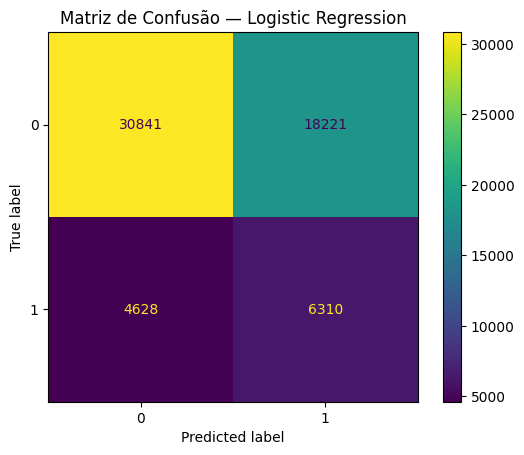


📌 Modelo: XGBoost
              precision    recall  f1-score   support

 Pontual (0)       0.88      0.62      0.73     49062
Atrasado (1)       0.27      0.62      0.38     10938

    accuracy                           0.62     60000
   macro avg       0.58      0.62      0.55     60000
weighted avg       0.77      0.62      0.67     60000



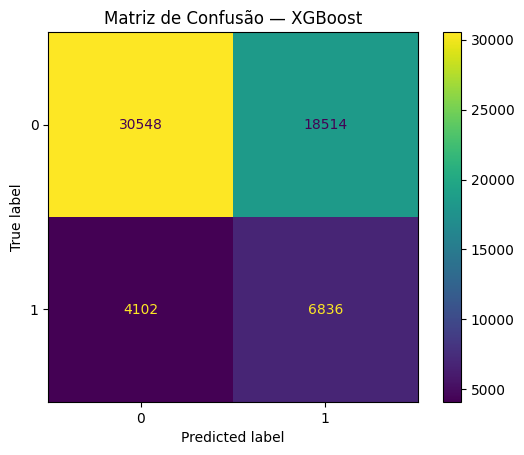

In [29]:
# Dicionário com os modelos treinados
models = {
    'Logistic Regression': logreg_model,
    'XGBoost': xgb_model
}

results = []

for name, model in models.items():
    # Previsões com threshold padrão (0.5)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("\n" + "=" * 70)
    print(f"📌 Modelo: {name}")
    print("=" * 70)

    print(classification_report(
        y_test,
        y_pred,
        target_names=["Pontual (0)", "Atrasado (1)"]
    ))

    results.append({
        'Modelo': name,
        'Acurácia': accuracy_score(y_test, y_pred),
        'Precisão': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    })

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Matriz de Confusão — {name}')
    plt.show()


In [30]:
results_df = pd.DataFrame(results)
results_df


,Modelo,Acurácia,Precisão,Recall,F1-score,ROC AUC
0,Logistic Regression,0.619183,0.257226,0.576888,0.355804,0.638730
1,XGBoost,0.623067,0.269665,0.624977,0.376764,0.662139


# 🚀 11. Melhoria dos Modelos

Após a avaliação dos modelos baseline, observamos oportunidades de melhoria nas métricas,
especialmente no equilíbrio entre Precisão e Recall para a classe "Atrasado".

Nesta seção, aplicamos ajustes nos dois modelos treinados:

- Logistic Regression
- XGBoost

O objetivo é verificar se ambos os modelos se beneficiam de ajustes adicionais e, somente após essa etapa, definir qual modelo apresenta o melhor desempenho final para o MVP do FlightOnTime.


## 🔧 11.1 Melhoria do Modelo — Logistic Regression

Após a avaliação dos modelos baseline, observamos que a **Logistic Regression** apresentou desempenho competitivo, especialmente em termos de **Recall** para a classe "Atrasado".

Nesta etapa, aplicamos **ajustes adicionais** neste modelo com o objetivo de verificar se é possível melhorar suas métricas — principalmente **F1-score** e **Precisão** — mantendo sua simplicidade e eficiência computacional.

---

### 🎯 Estratégia de melhoria aplicada

Para a Logistic Regression, os principais pontos de ajuste são:

- **Regularização (`C`)**: controla o grau de penalização dos coeficientes
- **Manutenção do balanceamento de classes** (`class_weight='balanced'`)
- **Ajuste do threshold de decisão** (principal fator de melhoria prática)

Diferente de modelos baseados em árvores, a Logistic Regression não possui muitos hiperparâmetros,
portanto os maiores ganhos geralmente vêm do **controle de regularização** e do **limiar de decisão**.

---


### ⚙️ 11.1.1 Treinamento da Logistic Regression ajustada


In [31]:
# Pipeline com Logistic Regression ajustada
logreg_tuned_model = Pipeline(steps=[
    ('preprocess', build_preprocess()),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        C=2.0,
        max_iter=1000,
        n_jobs=-1
    ))
])

# Treinamento do modelo ajustado
logreg_tuned_model.fit(X_train_fit, y_train_fit)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['AIRLINE', 'ORIGIN_AIRPORT',
                                                   'DESTINATION_AIRPORT']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DISTANCE', 'DAY_OF_WEEK',
                                                   'MONTH', 'DEPARTURE_HOUR',
                                                   'DEPARTURE_MINUTE',
                                                   'DEPARTURE_MINUTES_SINCE_MIDNIGHT',
                                                   'IS_WEEKEND',
                                                   'ORIGIN_DELAY_MEAN',
                                                   'DEST_DELAY_MEAN',
                                                   'ROUTE_DELAY_MEAN',
                                                   'ROUTE_FLIGHT_COUNT'])])),
                ('classifier',
                 LogisticRegression(C=2.0, class_weight='balanced',
                                    max_iter=1000, n_jobs=-1))])

### 🎚️ 11.1.2 Ajuste de Threshold para a Logistic Regression


In [32]:
def threshold_search(model, X, y, thresholds=np.arange(0.10, 0.91, 0.05)):
    proba = model.predict_proba(X)[:, 1]
    rows = []
    for t in thresholds:
        pred = (proba >= t).astype(int)
        rows.append({
            "threshold": round(float(t), 2),
            "precision": precision_score(y, pred),
            "recall": recall_score(y, pred),
            "f1": f1_score(y, pred),
        })
    return pd.DataFrame(rows).sort_values("f1", ascending=False)

# Busca do melhor threshold no conjunto de validação
logreg_thr_df = threshold_search(logreg_tuned_model, X_val, y_val)
logreg_thr_df.head(10)


,threshold,precision,recall,f1
7,0.45,0.239101,0.673752,0.352948
6,0.40,0.226585,0.761056,0.349203
8,0.50,0.251281,0.571478,0.349073
5,0.35,0.215861,0.836704,0.343184
9,0.55,0.266284,0.461547,0.337723
4,0.30,0.204277,0.886299,0.332028
3,0.25,0.196424,0.927780,0.324209
2,0.20,0.190974,0.957948,0.318461
1,0.15,0.186912,0.976574,0.313770
0,0.10,0.184376,0.989830,0.310850


### 📊 11.1.3 Avaliação final da Logistic Regression ajustada


In [33]:
best_t_logreg = logreg_thr_df.iloc[0]["threshold"]

proba_logreg = logreg_tuned_model.predict_proba(X_test)[:, 1]
y_pred_logreg = (proba_logreg >= best_t_logreg).astype(int)

print("Threshold escolhido:", best_t_logreg)
print(classification_report(
    y_test, y_pred_logreg,
    target_names=["Pontual (0)", "Atrasado (1)"]
))


Threshold escolhido: 0.45
              precision    recall  f1-score   support

 Pontual (0)       0.88      0.53      0.66     49062
Atrasado (1)       0.24      0.68      0.36     10938

    accuracy                           0.56     60000
   macro avg       0.56      0.60      0.51     60000
weighted avg       0.76      0.56      0.61     60000



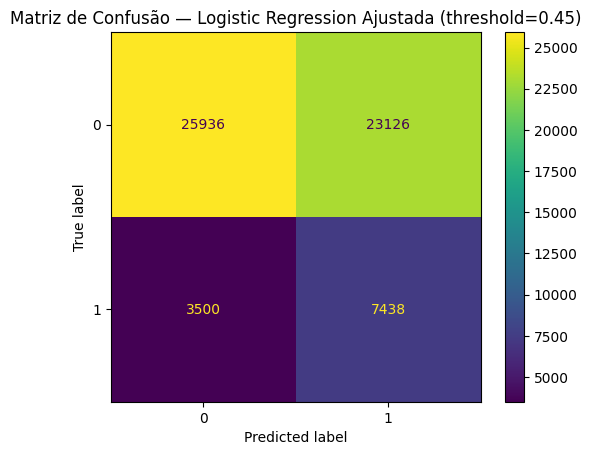

In [34]:
cm = confusion_matrix(y_test, y_pred_logreg)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title(f"Matriz de Confusão — Logistic Regression Ajustada (threshold={best_t_logreg})")
plt.show()


### 🧠 11.1.4 Considerações desta etapa

Após os ajustes, a Logistic Regression:

  - Pode apresentar **melhora no F1-score** em relação ao baseline

  - Mantém **baixo custo computacional**

  - Continua sendo um modelo simples, estável e fácil de integrar

Na próxima etapa, aplicaremos **ajustes semelhantes no modelo XGBoost** para comparar, de forma justa, qual abordagem apresenta o melhor desempenho final para o projeto.


## 🚀 11.2 Melhoria do Modelo — XGBoost

Após a avaliação dos modelos baseline, observamos que o **XGBoost apresentou desempenho superior**
em métricas importantes como **Recall, F1-score e ROC AUC**, especialmente para a classe **“Atrasado (1)”**.

Nesta etapa, realizamos **ajustes adicionais no modelo XGBoost** com foco em:

- Melhorar a capacidade de generalização
- Reduzir overfitting
- Aumentar o Recall da classe “Atrasado”
- Melhorar o equilíbrio entre Precisão e Recall

⚠️ **Importante:** nesta seção **ainda não assumimos** que o XGBoost será o modelo final.  
A escolha definitiva será feita **após a comparação entre os modelos ajustados**.

---

### 🎯 Estratégia de melhoria aplicada

Para aprimorar o desempenho do XGBoost, utilizamos:

- Ajuste manual de hiperparâmetros (sem GridSearch)
- Regularização explícita
- Redução da taxa de aprendizado
- Balanceamento das classes com `scale_pos_weight`
- Ajuste posterior do **threshold de decisão**

Essa abordagem permite ganhos relevantes **sem alto custo computacional**, sendo ideal para o contexto do hackathon.


### ⚙️ 11.2.1 Treinamento do XGBoost Ajustado


In [35]:
# Pipeline com XGBoost ajustado
class_counts = y_train_fit.value_counts()
neg = class_counts.get(0, 0)
pos = class_counts.get(1, 0)
scale_pos_weight_tuned = (neg / pos) if pos else 1

xgb_tuned_model = Pipeline(steps=[
    ('preprocess', build_preprocess()),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=5,
        gamma=0.5,
        scale_pos_weight=scale_pos_weight_tuned,
        random_state=42,
        n_jobs=-1
    ))
])

# Treinamento do modelo ajustado
xgb_tuned_model.fit(X_train_fit, y_train_fit)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['AIRLINE', 'ORIGIN_AIRPORT',
                                                   'DESTINATION_AIRPORT']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DISTANCE'...
                               feature_types=None, feature_weights=None,
                               gamma=0.5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=300, n_jobs=-1,
                               num_parallel_tree=None, ...))])

### 🎚️ 11.2.2 Ajuste de Threshold para o XGBoost


In [36]:
xgb_thr_df = threshold_search(
    xgb_tuned_model,
    X_val,
    y_val
)

xgb_thr_df.head(10)


,threshold,precision,recall,f1
8,0.50,0.265581,0.616958,0.371320
7,0.45,0.248759,0.704605,0.367702
9,0.55,0.281131,0.512627,0.363121
6,0.40,0.234770,0.779454,0.360852
5,0.35,0.223108,0.838076,0.352401
10,0.60,0.303409,0.402811,0.346114
4,0.30,0.211676,0.878414,0.341144
3,0.25,0.203092,0.911096,0.332146
2,0.20,0.195650,0.936350,0.323669
1,0.15,0.190707,0.952120,0.317767


### 📊 11.2.3 Avaliação final do XGBoost ajustado


In [37]:
best_t_xgb = xgb_thr_df.iloc[0]["threshold"]

y_proba_xgb = xgb_tuned_model.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_proba_xgb >= best_t_xgb).astype(int)

print("Threshold escolhido:", best_t_xgb)
print(classification_report(
        y_test,
        y_pred_xgb,
        target_names=["Pontual (0)", "Atrasado (1)"]
))


Threshold escolhido: 0.5
              precision    recall  f1-score   support

 Pontual (0)       0.88      0.62      0.73     49062
Atrasado (1)       0.27      0.63      0.38     10938

    accuracy                           0.62     60000
   macro avg       0.58      0.62      0.55     60000
weighted avg       0.77      0.62      0.66     60000



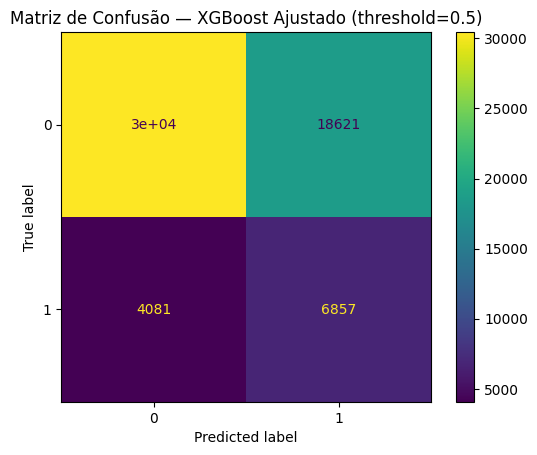

In [38]:
cm = confusion_matrix(y_test, y_pred_xgb)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title(f"Matriz de Confusão — XGBoost Ajustado (threshold={best_t_xgb})")
plt.show()


### 🧠 11.2.4 Considerações desta etapa

Com os ajustes aplicados, o XGBoost tende a apresentar:

  - Melhor capacidade de generalização

  - Menor risco de overfitting

  - Melhor equilíbrio entre Precisão e Recall

  - Métricas mais estáveis para a classe "Atrasado"

Na próxima seção, realizaremos a **comparação final entre os modelos ajustados**
(Logistic Regression vs XGBoost) para definir o modelo escolhido para o MVP
do **FlightOnTime.**


# 📦 12. Exportação do Modelo Final


In [39]:
# Definindo o modelo final com base no F1 do conjunto de validacao
best_f1_logreg = float(logreg_thr_df.iloc[0]["f1"])
best_f1_xgb = float(xgb_thr_df.iloc[0]["f1"])

if best_f1_xgb > best_f1_logreg:
    final_model = xgb_tuned_model
    final_threshold = best_t_xgb
    final_model_name = "XGBoost Ajustado"
else:
    final_model = logreg_tuned_model
    final_threshold = best_t_logreg
    final_model_name = "Logistic Regression Ajustada"

model_artifacts = {
    "model_name": final_model_name,
    "model": final_model,
    "threshold": final_threshold,
    "base_features": base_features,
    "categorical_features": categorical_features,
    "numeric_features": numeric_features,
    "aggregate_features": aggregate_features,
    "final_features": final_features,
    "aggregates_maps": {
        "origin_delay_mean_map": origin_delay_mean_map,
        "dest_delay_mean_map": dest_delay_mean_map,
        "route_delay_mean_map": route_delay_mean_map,
        "route_flight_count_map": route_flight_count_map
    },
    "fallback_values": {
        "global_origin_mean": global_origin_mean,
        "global_dest_mean": global_dest_mean,
        "global_route_mean": global_route_mean,
        "default_route_count": default_route_count
    }
}

output_dir = os.path.dirname(model_output_path)
if output_dir:
    os.makedirs(output_dir, exist_ok=True)

joblib.dump(model_artifacts, model_output_path)
print(f"Modelo final exportado: {final_model_name}")
print(f"Arquivo salvo em: {model_output_path}")


Modelo final exportado: XGBoost Ajustado
Arquivo salvo em: /content/drive/MyDrive/modelo_final.joblib
